# Spotify Playlist - Application

After deducing that KMeans would be the preffered algorithm for this problem, it will be applied to my Liked Songs on Spotify, and then a certain number of new playlists would be generated based on the formed clusters.

The first step is importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import time
import spotipy
from spotipy import SpotifyClientCredentials, util
from yellowbrick.cluster import KElbowVisualizer
import statistics

client_id='your-client-id'
client_secret='your-client-secret'
username='your-spotify-username'
scope = 'user-library-modify'
scope_playlist = 'playlist-modify-public'
redirect_uri='your-redirect-uri'

#Credentials to access the Spotify Music Data
manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

#Credentials to access Spotify user data
token = util.prompt_for_user_token(username,scope,client_id,client_secret,redirect_uri) 
spt = spotipy.Spotify(auth=token)

#Credentials to modify user's playlists
token_playlist= util.prompt_for_user_token(username,scope_playlist,client_id,client_secret,redirect_uri) 
sp_playlist = spotipy.Spotify(auth=token_playlist)

The following part defines the necessary functions, all of which are familiar from previous notebooks, but this time data is retrieved from a Spotify account and not the dataset

In [2]:
#Get Liked Songs from user's Spotify and obtain track IDs
def get_track_ids():
    track_ids = []
    for i in range(0,100,50):
        track_results = spt.current_user_saved_tracks(limit=50,offset=i)
        for item in track_results['items']:
            track = item['track']
            track_ids.append(track['uri'].split(':')[-1])
    return track_ids

In [3]:
#Declare function to obtain track features based on a track ID
def get_track_features(id):

    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']
    ids =  meta['id']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    key = features[0]['key']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, ids, release_date, popularity, length, danceability, acousticness,
            energy, instrumentalness, liveness, valence, loudness, speechiness, tempo, key, time_signature]
    columns = ['name','album','artist','id','release_date','popularity','length','danceability','acousticness','energy','instrumentalness',
                'liveness','valence','loudness','speechiness','tempo','key','time_signature']
    return track,columns

In [4]:
#Create a DataFrame of all the playlist tracks and their respective features
def create_playlist_dataframe(track_ids):
    tracks = []
    for track_id in track_ids:
        time.sleep(.2)
        track, columns = get_track_features(track_id)
        tracks.append(track)
    df1 = pd.DataFrame(tracks,columns=columns)
    return df1

In [5]:
#Extract only necessary features from the df
def extract_features(df1):
    df = df1[['name','album','artist','id','release_date','popularity','danceability','energy','valence','loudness']]
    return df

In [6]:
#Scale the features
def scale_features(df):
    col_features = df.columns[6:]
    X = StandardScaler().fit_transform(df[col_features])
    return X

In [7]:
#Use the elbow model to find the ideal number of clusters, relying on distortion metric 
def elbow_model(X):
    model = KElbowVisualizer(KMeans(), k=9)
    model.fit(X)
    return model

In [8]:
#Apply kmeans clustering
def perform_clustering(X, model, df):
    kmeans = KMeans(init="k-means++", n_clusters=model.elbow_value_).fit(X)
    result = df.copy(deep=True)
    result['kmeans'] = kmeans.labels_
    score = silhouette_score(X, kmeans.labels_, metric='euclidean')
    return result, score

Now the procedure will be applied in order to get the clusters

0.25296798646429425

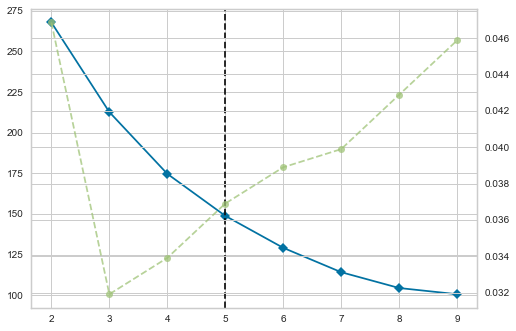

In [10]:
#Perform algorithm
track_ids = get_track_ids()
df1 = create_playlist_dataframe(track_ids)
df = extract_features(df1)
X = scale_features(df)
model = elbow_model(X)
result, score = perform_clustering(X, model, df)
score

Text(0.5, 0.92, '3D Scatter Plot of Songs Clustered')

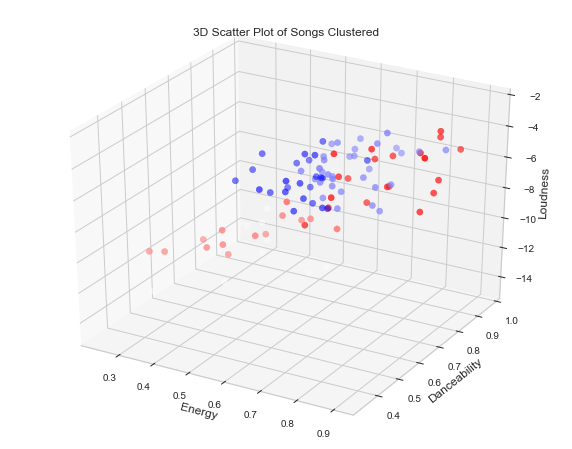

In [11]:
#Create a 3D scatter plot of clustered songs
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

x = result['energy']
y = result['danceability']
z = result['loudness']
cmhot = cmhot = plt.get_cmap('bwr')

ax.scatter(x,y,z,c=result['kmeans'],s=40,cmap=cmhot)
ax.set_xlabel('Energy',fontsize=12)
ax.set_ylabel('Danceability',fontsize=12)
ax.set_zlabel('Loudness',fontsize=12)
ax.set_title("3D Scatter Plot of Songs Clustered")

After successful clustering, new playlists will be created based on the clusters, and within each playlist a few tracks will be appended to expand them based on their audio features

In [40]:
#Separating the clusters into new variables and extracting track ids
for i in range(0, model.elbow_value_):
    cluster_name = 'cluster_' + str(i)
    cluster_name = result[result['kmeans']==i]

In [110]:
cluster_0.head()

,name,album,artist,id,release_date,popularity,danceability,energy,valence,loudness,kmeans
2,chosen,chosen,Dua Saleh,0rT7hDCDu6euX1kkWT0JdV,2022-06-17,39,0.809,0.460,0.3790,-8.581,0
9,Before I Die/Play No Games,Before I Die/Play No Games,Ayzha,5kPHBTW36g518SZtTAXqEc,2022-04-07,43,0.694,0.523,0.1710,-7.489,0
11,Swim,Chase Atlantic,Chase Atlantic,3M0lSi5WW79CXQamgSBIjx,2017-10-04,83,0.666,0.542,0.0771,-6.429,0
16,Plan B,Plan B,Megan Thee Stallion,2PljnVsnl2PRwCvfhbdQup,2022-04-22,78,0.787,0.522,0.6660,-5.872,0
18,Don't Rush (feat. Headie One),Don't Rush (feat. Headie One),Young T & Bugsey,0PXukVbYpvz40KcEFKnIw7,2019-11-07,64,0.961,0.461,0.3240,-8.684,0


In [119]:
#Obtaining the ids of the songs and converting to lists
ids_0 = cluster_0['id'].tolist()
ids_1 = cluster_1['id'].tolist()
ids_2 = cluster_2['id'].tolist()
ids_3 = cluster_3['id'].tolist()
ids_4 = cluster_4['id'].tolist()
print('Playlist 0: ' + str(len(ids_0)))
print('Playlist 1: ' + str(len(ids_1)))
print('Playlist 2: ' + str(len(ids_2)))
print('Playlist 3: ' + str(len(ids_3)))
print('Playlist 4: ' + str(len(ids_4)))

Playlist 0: 25
Playlist 1: 31
Playlist 2: 10
Playlist 3: 14
Playlist 4: 20


In [120]:
#Get a recommended track for every 5 tracks in the original playlist and append it
def append_recommended_tracks(tracks):
    for i in range(5, len(tracks)+1, 5):
        result = sp.recommendations(seed_tracks=tracks[i-5:i], limit=5)
        recomms = pd.DataFrame(result)
        tracks.append(recomms['tracks'][0]['id'])

In [121]:
append_recommended_tracks(ids_0)
append_recommended_tracks(ids_1)
append_recommended_tracks(ids_2)
append_recommended_tracks(ids_3)
append_recommended_tracks(ids_4)
print('Playlist 0: ' + str(len(ids_0)))
print('Playlist 1: ' + str(len(ids_1)))
print('Playlist 2: ' + str(len(ids_2)))
print('Playlist 3: ' + str(len(ids_3)))
print('Playlist 4: ' + str(len(ids_4)))

Playlist 0: 30
Playlist 1: 37
Playlist 2: 12
Playlist 3: 16
Playlist 4: 24


In [116]:
#Creating new playlists on my Spotify account
pl_0 = sp_playlist.user_playlist_create(user=username, name="Playlist 0")
pl_1 = sp_playlist.user_playlist_create(user=username, name="Playlist 1")
pl_2 = sp_playlist.user_playlist_create(user=username, name="Playlist 2")
pl_3 = sp_playlist.user_playlist_create(user=username, name="Playlist 3")
pl_4 = sp_playlist.user_playlist_create(user=username, name="Playlist 4")

In [123]:
#Adding the tracks into the playlists

sp_playlist.user_playlist_add_tracks(user=username, playlist_id = pl_0['id'], tracks=ids_0)
sp_playlist.user_playlist_add_tracks(user=username, playlist_id = pl_1['id'], tracks=ids_1)
sp_playlist.user_playlist_add_tracks(user=username, playlist_id = pl_2['id'], tracks=ids_2)
sp_playlist.user_playlist_add_tracks(user=username, playlist_id = pl_3['id'], tracks=ids_3)
sp_playlist.user_playlist_add_tracks(user=username, playlist_id = pl_4['id'], tracks=ids_4)

{'snapshot_id': 'Miw1YTQzYTRjNjMwOWQ2NDEwNGFhNGMzNjBlYTRiODZlMGVkNGRhZDcx'}